## 0. Import relevant libraries

In [1]:
print('Importing packages...')

import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import scipy
from scipy import optimize
from scipy.optimize import leastsq
from datetime import datetime
from matplotlib import cm
from lmfit import Model
from scipy.optimize import curve_fit

print('done')


Importing packages...
done


## 0. Import spectra

In [2]:
%run Functions.py
%run Load_data.py

Files have been created 


 Sample files:
file14
file15
file16
file19
file20
file21

 Vacuum files:
file17
file22
file23

 Total samples file: "df" 
                   x             y     x_shifted        y_norm         log_y
count  11886.000000  1.188600e+04  11886.000000  11886.000000  11886.000000
mean      20.708500  2.943846e+04     20.750000      0.020192      8.097109
std       14.297236  1.957346e+05     14.297236      0.134208      1.210722
min       -4.041500  2.765300e+02     -4.000000      0.000190      5.622319
25%        8.333500  1.351622e+03      8.375000      0.000932      7.209061
50%       20.708500  3.076860e+03     20.750000      0.002106      8.031665
75%       33.083500  5.665987e+03     33.125000      0.003879      8.642236
max       45.458500  2.440470e+06     45.500000      1.640224     14.707701

 Total vacuum file: "df_vacuum" 
                  x             y    x_shifted       y_norm
count  5943.000000  5.943000e+03  5943.000000  5943.000000
mean     20.7

## 1. Create dataframe with all individual spectra

In [27]:
cols=['y14', 'x14', 'y15', 'x15', 'y16', 'x16', 'y17', 'x17', 'y19', 'x19', 'y20', 'x20', 'y21', 'x21', 'y22', 'x22', 'y23', 'x23']

ZLP_data = pd.concat((file14, file15, file16, file17, file19, file20, file21, file22, file23), axis=1)
ZLP_data = ZLP_data.drop(['x', 'y_norm'],axis=1).rename(columns={'x_shifted': 'x'})
ZLP_data.columns = cols


## Window the data file to the desired energy range
E_min = -.3
E_max = 20
original = ZLP_data[(ZLP_data['x14'] >= E_min) & (ZLP_data['x14'] <= E_max)]


## 2. Load results files

### 2a. List files with x$_{train}$ and y$_{pred}$

In [28]:
d_string = '07.09.2020'

path_to_data = 'Data/Results/%(date)s/'% {"date": d_string} 

path_predict = r'Predictions_*.csv'
path_cost = r'Cost_*.csv' 
path_extrapolate = path_4 = r'Extrapolation_*.csv'

all_files = glob.glob(path_to_data + path_predict)

li = []
for filename in all_files:
    df = pd.read_csv(filename, delimiter=",",  header=0, usecols=[0,1,2], names=['x', 'y', 'pred'])
    li.append(df)
    
training_data = pd.concat(li, axis=0, ignore_index=True)

### 2b.  Load all values for cost$_{train}$ and cost$_{val}$

In [29]:
all_files_cost = glob.glob(path_to_data + path_cost)

In [30]:
all_files_cost_sorted = np.sort(all_files_cost)

chi2_array = []
chi2_index = []

for filename in all_files_cost_sorted:
    df = pd.read_csv(filename, delimiter=",", header=0, usecols=[0,1], names=['train', 'test'])
    best_try = np.argmin(df['test'])
    chi2_array.append(df.iloc[best_try,0])
    chi2_index.append(best_try)

chi_data  = pd.DataFrame()
chi_data['Best chi2 value'] = chi2_array
chi_data['Epoch'] = chi2_index
    
print("total length of files:", len(chi2_array))

total length of files: 100


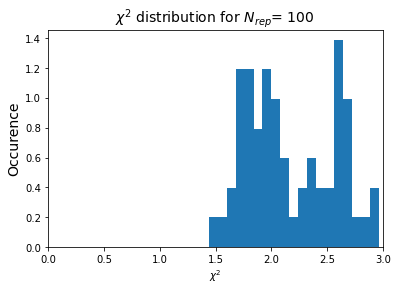

In [31]:
plt.hist(chi_data['Best chi2 value'], density=True, bins=50, range=[0, 4])
plt.title('title')
plt.xlabel('Error')
plt.title('$\chi^2$ distribution for $N_{rep}$= %(s)s ' % {"s": len(chi2_array)}, fontsize=14)
plt.xlabel('$\chi^2$')
plt.xlim([0, 3])
plt.ylabel('Occurence', fontsize=14)
plt.show()

## 3. Post-selection criteria

Remove all files that ended up with an error higher than a certain threshold.

In [32]:
good_files = []
count = 0
threshold = 3

for i,j in enumerate(chi2_array):
    if j < threshold:
        good_files.append(1) 
        count +=1 
    else:
        good_files.append(0)

print("Setting the threshold at", threshold, ", the number of files that survived the selection is", count)

Setting the threshold at 3 , the number of files that survived the selection is 60


## Load extrapolation data

For each replica, the prediction should be taken separately:\
     $substracted\_spectrum_k = original\_spectrum - ZLP_k$

In [33]:
extrapolation_files = glob.glob(path_to_data + path_extrapolate)
extrapolation_files_sorted = np.sort(extrapolation_files)
use_files = []

for i,j in enumerate(good_files):
    if j == 1:
        file = extrapolation_files_sorted[i]
        use_files.append(file)

# All datafiles have been imported. 
### We can now move on to the evaluation of the ZLP predictions

## 4. Subtraction

In [34]:
dE1 = np.round(max(training_data['x'][(training_data['x']< 3)]),2)
dE2 = np.round(min(training_data['x'][(training_data['x']> 3)]),1)
dE0 = np.round(dE1 - .5, 2) 

print('The values for dE0, dE1 and dE2:', dE0, dE1, dE2)

The values for dE0, dE1 and dE2: 1.38 1.88 12.0


In [35]:
### Definition for the matching procedure

def matching(x, y_NN, y_ZLP):
    
    total = pd.DataFrame({"x": x, "prediction y": y_NN, "data ZLP": y_ZLP})
    
    delta = np.divide((dE1 - dE0), 3)

    factor_NN = np.exp(- np.divide((x[(x<dE1) & (x >= dE0)] - dE1)**2, delta**2))
    factor_ZLP = 1 - factor_NN
    
    range_0 = total[total['x'] < dE0]['data ZLP'] * 1
    range_1 = total[(total['x'] < dE1) & (total['x'] >= dE0)]['prediction y'] * factor_NN + total[(total['x'] < dE1) & (total['x'] >= dE0)]['data ZLP'] * factor_ZLP
    range_2 = total[(total['x'] >= dE1) & (total['x'] < 3 * dE2)]['prediction y'] * 1 
    range_3 = total[(total['x'] >= 3 * dE2)]['prediction y'] * 0
    totalfile = np.concatenate((range_0, range_1, range_2, range_3), axis=0)
    
    return totalfile

In [36]:
### Definition for the bandgap fitting

def bandgap(x, amp, BG,b):
    return amp * (x - BG)**(b)

bmodel = Model(bandgap)


### Below, we loop over all the replicas and create a big dataframe 'replica_file' that contains all predictions

Since the arrays 'predict_x' and 'train_x' are not necessarily of the same length, we evaluate the prediction made for the vector predict_x by taking as many data points as the original spectra. This way we reshape the prediction such that we can directly subtract the predicted ZLP from the original spectrum.


For each replica $k$, the NN gives a prediction on the ZLP: $ZLP_k$. The substracted spectrum at each iteration is then $Substraction_k = original\_spectrum - ZLP_k$.  

In [46]:
nbins = len(original['x14'])
li = []
diff = []
count = 0

for filename in use_files:
    df = pd.read_csv(filename, delimiter=",", header=None, usecols=[0,1], names=['x', 'prediction'])
    df['k'] = count
    li.append(df)
    count += 1
    
### Window the prediction data to the same energy range as the original spectra
    
extrapolation = extrapolation[(extrapolation['x'] >= E_min) & (extrapolation['x'] <= E_max)]
extrapolation.describe()

,x,prediction,k
count,178200.000000,178200.000000,178200.000000
mean,9.852534,2.361244,29.500000
std,5.860632,3.703050,17.318151
min,-0.294932,0.421677,0.000000
25%,4.777092,0.488270,14.750000
50%,9.852534,0.533257,29.500000
75%,14.927976,1.607460,44.250000
max,20.000000,14.844770,59.000000


In [40]:
lo = []

for k in range(count): 
    exp_k = extrapolation[extrapolation['k'] == k ]
    nbins = len(original['x14'])  
    mean_k, var_k, count = binned_statistics(exp_k['x'], exp_k['prediction'], nbins)[0:3]
    
    replica_file = pd.DataFrame({"k": k, \
                                 "x14": original['x14'], \
                                 "x15": original['x15'], \
                                 "x16": original['x16'], \
                                 "x19": original['x19'], \
                                 "x20": original['x20'], \
                                 "x21": original['x21'],\
                                 #
                               "prediction log(y1)": mean_k, \
                               "prediction y": np.exp(mean_k), \
                                 #
                               "data y14": original['y14'], \
                               "data y15": original['y15'], \
                               "data y16": original['y16'], \
                               "data y19": original['y19'], \
                               "data y20": original['y20'], \
                               "data y21": original['y21'], \
                                #
                                     "match14": matching(original['x14'], np.exp(mean_k), original['y14']), \
                                     "match15": matching(original['x15'], np.exp(mean_k), original['y15']), \
                                     "match16": matching(original['x16'], np.exp(mean_k), original['y16']), \
                                     "match19": matching(original['x19'], np.exp(mean_k), original['y19']), \
                                     "match20": matching(original['x20'], np.exp(mean_k), original['y20']), \
                                     "match21": matching(original['x21'], np.exp(mean_k), original['y21']), })
    lo.append(replica_file)
    
total_replicas = pd.concat(lo, axis=0, ignore_index = True, sort=False)

### Subtracted spectra:  difference = original spectrum - matched spectrum

for i in ([14, 15, 16, 19, 20, 21]):
    total_replicas['dif%(i)s'%{"i": i}] = total_replicas['data y%(i)s'%{"i": i}] - total_replicas['match%(i)s'%{"i": i}]

total_replicas.to_csv('Data/Results/Replica_files/final_%(s)s' % {"s": dE1})

In [41]:
total_replicas.describe()

,k,x14,x15,x16,x19,x20,x21,prediction log(y1),prediction y,data y14,...,match16,match19,match20,match21,dif14,dif15,dif16,dif19,dif20,dif21
count,48780.00000,48780.000000,48780.000000,48780.000000,48780.000000,48780.000000,48780.000000,48780.000000,4.878000e+04,4.878000e+04,...,4.878000e+04,4.878000e+04,4.878000e+04,4.878000e+04,48780.000000,48780.000000,48780.000000,48780.000000,48780.000000,48780.000000
mean,29.50000,9.850000,9.850000,9.850000,9.850000,9.850000,9.850000,2.359665,6.082803e+04,6.505895e+04,...,6.111732e+04,5.875312e+04,6.021710e+04,6.285571e+04,3453.447396,3539.244510,3417.444090,3613.480051,3529.635410,3303.172331
std,17.31828,5.867378,5.867378,5.867378,5.867378,5.867378,5.867378,3.700761,3.044128e+05,3.056149e+05,...,3.043136e+05,2.914660e+05,2.992293e+05,3.133116e+05,1801.657492,1903.192975,1806.713935,2031.733120,1943.176387,1652.215981
min,0.00000,-0.300000,-0.300000,-0.300000,-0.300000,-0.300000,-0.300000,0.421679,1.524519e+00,2.145750e+03,...,1.524519e+00,1.524519e+00,1.524519e+00,1.524519e+00,-1066.974089,-1229.466289,-1343.857545,-1554.833706,-1407.904089,-897.231051
25%,14.75000,4.775000,4.775000,4.775000,4.775000,4.775000,4.775000,0.488270,1.629496e+00,3.084790e+03,...,1.629496e+00,1.629496e+00,1.629496e+00,1.629496e+00,2723.306231,2883.628736,2689.915094,2735.867221,2719.657796,2782.938620
50%,29.50000,9.850000,9.850000,9.850000,9.850000,9.850000,9.850000,0.533257,1.704475e+00,3.557280e+03,...,1.704475e+00,1.704475e+00,1.704475e+00,1.704475e+00,3308.792277,3311.131012,3255.991493,3352.959532,3334.464541,3128.580791
75%,44.25000,14.925000,14.925000,14.925000,14.925000,14.925000,14.925000,1.606753,4.986596e+00,5.702870e+03,...,4.986596e+00,4.986596e+00,4.986596e+00,4.986596e+00,4639.534497,4690.354484,4601.244495,4907.734478,4730.364490,4339.474487
max,59.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,14.836666,2.776401e+06,2.377200e+06,...,2.360060e+06,2.255460e+06,2.327880e+06,2.440470e+06,6939.015389,7631.415470,7091.705273,7600.534704,7536.045236,6811.865022


## 5. Evaluate subtracted spectra

In [42]:
mean_rep = pd.DataFrame()
total_bins = len(original['x14'])

mean_pred, sigma_pred = \
    binned_statistics(total_replicas['x14'], total_replicas['prediction y'], nbins)[0:2]

pred_high, pred_low = binned_statistics(total_replicas['x14'], total_replicas['prediction y'], nbins)[3:5]

mean_rep['pred'] = mean_pred
mean_rep['pred_high'], mean_rep['pred_low'] = pred_high, pred_low
total_replicas.loc[:, 'dif14'][total_replicas.loc[:, 'dif14'] < 0] = 0
wl = 4

for i in ([14, 15, 16, 19, 20, 21]):
    mean_dif, var_dif =  binned_statistics(total_replicas['x%(i)s'%{"i":i}], 
                                           total_replicas['dif%(i)s'%{"i":i}], total_bins)[0:2]
    dif_high, dif_low =  binned_statistics(total_replicas['x%(i)s'%{"i":i}], 
                                           total_replicas['dif%(i)s'%{"i":i}], total_bins)[3:5]
    dif_median = get_median(total_replicas['x%(i)s'%{"i":i}], 
                                           total_replicas['dif%(i)s'%{"i":i}], total_bins)
    
    mean_rep['dif%(i)s'%{"i":i}],mean_rep['sigma_dif%(i)s'%{"i":i}] = smooth(mean_dif, wl), smooth(var_dif, wl)
    mean_rep['dif%(i)s_high'%{"i":i}],mean_rep['dif%(i)s_low'%{"i":i}] = \
                                            smooth(dif_high, wl),smooth(dif_low, wl)
    mean_rep['dif%(i)s_median'%{"i":i}] = smooth(dif_median, wl)
    
    mean_match, var_match = binned_statistics(total_replicas['x%(i)s'%{"i":i}], 
                                           total_replicas['match%(i)s'%{"i":i}], total_bins)[0:2]
    match_high, match_low =  binned_statistics(total_replicas['x%(i)s'%{"i":i}], 
                                           total_replicas['match%(i)s'%{"i":i}], total_bins)[3:5]
    
    match_median = get_median(total_replicas['x%(i)s'%{"i":i}], 
                                           total_replicas['match%(i)s'%{"i":i}], total_bins)
    
    mean_rep['match%(i)s'%{"i":i}], mean_rep['sigma_match%(i)s'%{"i":i}] = \
                                            smooth(mean_match, wl), smooth(var_match, wl)
    mean_rep['match%(i)s_high'%{"i":i}], mean_rep['match%(i)s_low'%{"i":i}] = \
                                            smooth(match_high, wl), smooth(match_low, wl)
    mean_rep['match%(i)s_median'%{"i":i}] = smooth(match_median, wl)
    
    mean_rep['spectrum%(i)s'%{"i":i}] = smooth(original['y%(i)s'%{"i":i}], wl)

<ipython-input-42-95f4fc38ce79>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_replicas.loc[:, 'dif14'][total_replicas.loc[:, 'dif14'] < 0] = 0


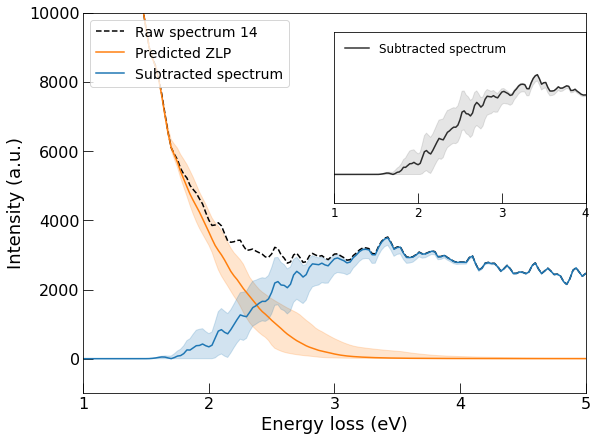

In [54]:
nrows, ncols = 1,1
gs = matplotlib.gridspec.GridSpec(nrows,ncols)
plt.figure(figsize=(ncols*9,nrows*7))

cm_subsection = np.linspace(0,1,24) 
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

hfont = rc('font',**{'family':'sans-serif','sans-serif':['Sans Serif']})

for i in range(1):
    ax = plt.subplot(gs[i])
    ax.set_xlim([1,5])
    ax.set_ylim([-1e3,1e4])
    ax.set_ylabel('Intensity (a.u.)', fontsize=18)
    ax.set_xlabel('Energy loss (eV)', fontsize=18)
    
    ax.tick_params(which='major',direction='in',length=10, labelsize=16)
    ax.tick_params(which='minor',length=10)
    ax.set_xticks([1, 2, 3, 4, 5])
    
    ax.plot(np.linspace(E_min, E_max, nbins), mean_rep['spectrum14'], 'k--', label='Raw spectrum 14')
    ax.plot(np.linspace(E_min, E_max, nbins), mean_rep['match14_median'], color=colors[1], label='Predicted ZLP')
    ax.fill_between(np.linspace(E_min, E_max, nbins), mean_rep['match14_low'], mean_rep['match14_high'], \
                    color=colors[1], alpha=.2)
    
    ax.plot(np.linspace(E_min, E_max, nbins), mean_rep['dif14_median'], color=colors[0], label='Subtracted spectrum')
    ax.fill_between(np.linspace(E_min, E_max, nbins), mean_rep['dif14_low'], mean_rep['dif14_high'], color=colors[0], alpha=.2)
    

    ax.legend(loc='upper left', fontsize = 14)
    
    axins = ax.inset_axes([0.50, 0.5, 0.5, 0.45])
    
    axins.get_xaxis().set_visible(True)
    axins.get_yaxis().set_visible(True)
    axins.spines['right'].set_visible(True)
    axins.spines['top'].set_visible(True)
    axins.set_xticks([1, 2, 3, 4])
    axins.set_xlim([1,4])
    axins.set_ylim([-1e3, 5e3])
    
    axins.plot(np.linspace(E_min, E_max, nbins), mean_rep['dif14_median'], 'k-', alpha=.8, label='Subtracted spectrum')
    axins.fill_between(np.linspace(E_min, E_max, nbins), mean_rep['dif14_low'], \
                       mean_rep['dif14_high'], color='black', alpha=.1)
    axins.tick_params(which='both',direction='in', labelsize=12,right=True)
    axins.tick_params(which='major',length=10)
    axins.tick_params(which='minor',length=10)
    axins.set_yticks([])
    axins.legend(loc='upper left', fontsize=12, frameon=False)
